In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from types import SimpleNamespace
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import wavfile
from scipy.signal import correlate, lfilter, medfilt, butter
from numpy.fft import fft, ifft
from matplotlib.pyplot import plot
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input/test"))

# Any results you write to the current directory are saved as output.

['M3.wav', 'M1.wav', 'F1.wav', 'F5.wav', 'F4.wav', 'M2.wav', 'M5.wav', 'F2.wav', 'F3.wav', 'M4.wav']


In [2]:
def noise_cancelling(frame):
    n = 7 # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    frame = lfilter(b,a,frame)
    return frame

In [3]:
def cepstrum_methodAdri(frame, sfreq, threshold, fmin, fmax):
    frame = noise_cancelling(frame)
    frame = frame.astype(np.float)
    frame_fft = np.absolute(fft(frame))
    log_frame_fft = np.log10(frame_fft)
    frame_ifft = ifft(log_frame_fft)
    frame_cep = frame_ifft[:len(frame_ifft)//2]
    dcep = np.diff(frame_cep)
    rmin = np.where(dcep > 0)[0]
    if len(rmin) > 0:
        rmin1 = rmin[0]
    else:
        return 0
    
    peak = np.argmax(frame_cep[rmin1:]) + rmin1
    rmax = frame_cep[peak]/frame_cep[0]
    f0 = sfreq / peak
    if rmax > threshold and f0 >= fmin and f0 <= fmax:
        return f0
    else:
        return 0
    

In [4]:
def lowpass_filter(frame, cutOffreq, sfreq, order):
    b, a = butter_lowpass(cutOffreq, sfreq, order=order)
    y = lfilter(b, a, frame)
    return y

In [5]:
def butter_lowpass(cutOffreq, sfreq, order):
    nyq = 0.5 * sfreq
    normalCutoff = cutOffreq / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

In [6]:
#from cepstrum-2-method
def cepstrum_analysis(frame,sfreq):

    spectrum = np.fft.rfft(frame)
    log_spectrum = np.log(np.abs(spectrum**2))
    cep = np.fft.irfft(log_spectrum)

    return cep

In [7]:
def cepstrum_methodRamon(frame,sfreq):

    #Filter parameters
    cutOff = 700
    fs = sfreq
    order = 20
    frame = noise_cancelling(frame)
    windowed = lowpass_filter(frame, cutOff, fs, order)
    windowed = windowed.astype(np.float)
    #windowed -= windowed.mean()
    amax = np.abs(windowed).max()
    
    if amax > 0:
            windowed /= amax
    else:
           return 0
        
    if medfilt(abs(frame),kernel_size = 21).mean() < 200:
           return 0

    cep = cepstrum_analysis(windowed,sfreq)
    corr = correlate(cep, cep) 
    
    # keep the positive part of the frequency range
    corr = corr[len(corr)//2:]

    #definition of the observation window
    Fmin=50
    Fmax=700

    minimum =int(sfreq/Fmax)
    maximum =int(sfreq/Fmin)

    peak = np.argmax(corr[minimum:maximum]) + minimum
    
    if  peak == 0:
        return 0
    else:
        f0= sfreq / peak

    if  f0 > 50 and f0 < 400:
            return f0
    else:
            return 0; 

In [8]:
def autocorr_method(frame, sfreq, threshold=0.3, fmin=50, fmax=400):
    """Estimate pitch using autocorrelation
    """

    # Calculate autocorrelation using scipy correlate
    frame = noise_cancelling(frame)
    framebo= frame
    frame = frame.astype(np.float)
    frame -= frame.mean()
    amax = np.abs(frame).max()
    if amax > 0:
        frame /= amax
    else:
        return 0

    corr = correlate(frame, frame)
    # keep the positive part
    corr = corr[len(corr)//2:]

    # Find the first minimum
    dcorr = np.diff(corr)
    rmin = np.where(dcorr > 0)[0]
    if len(rmin) > 0:
        rmin1 = rmin[0]
    else:
        return 0

    # Find the next peak
    peak = np.argmax(corr[rmin1:]) + rmin1
    rmax = corr[peak]/corr[0]
    f0 = sfreq / peak
    if medfilt(abs(framebo),kernel_size = 33).mean() < 185:
        return 0

    if  rmax>threshold and f0 >= fmin and f0 <= fmax:
        return f0
    else:
        return 0

In [9]:
class Counters:
    def __init__(self, gross_threshold=0.2):
        self.num_voiced = 0
        self.num_unvoiced = 0
        self.num_voiced_unvoiced = 0
        self.num_unvoiced_voiced = 0
        self.num_voiced_voiced = 0
        self.num_gross_errors = 0
        self.fine_error = 0
        self.e2 = 0
        self.gross_threshold = gross_threshold
        self.nfiles = 0

    def add(self, other):
        if other is not None:
            self.num_voiced += other.num_voiced
            self.num_unvoiced += other.num_unvoiced
            self.num_voiced_unvoiced += other.num_voiced_unvoiced
            self.num_unvoiced_voiced += other.num_unvoiced_voiced
            self.num_voiced_voiced += other.num_voiced_voiced
            self.num_gross_errors += other.num_gross_errors
            self.fine_error += other.fine_error
            self.e2 += other.e2
            self.nfiles += 1

    def __repr__(self):
        nframes = self.num_voiced + self.num_unvoiced
        if self.nfiles > 0:
            self.fine_error /= self.nfiles
        str = [
            f"Num. frames:\t{self.num_unvoiced + self.num_voiced} = {self.num_unvoiced} unvoiced + {self.num_voiced} voiced",
            f"Unvoiced frames as voiced:\t{self.num_unvoiced_voiced}/{self.num_unvoiced} ({100*self.num_unvoiced_voiced/self.num_unvoiced:.2f}%)",
            f"Voiced frames as unvoiced:\t{self.num_voiced_unvoiced}/{self.num_voiced} ({100*self.num_voiced_unvoiced/self.num_voiced:.2f}%)",
            f"Gross voiced errors (>{100*self.gross_threshold}%):\t{self.num_gross_errors}/{self.num_voiced_voiced} ({100*self.num_gross_errors/self.num_voiced_voiced:.2f}%)",
            f"MSE of fine errors:\t{100*self.fine_error:.2f}%",
            f"RMSE:\t{np.sqrt(self.e2/nframes):.2f}"
        ]
        return '\n'.join(str)

In [10]:
def compare(fref, pitch):
    vref = np.loadtxt(fref)
    vtest = np.array(pitch)

    diff_frames = len(vref) - len(vtest)
    if abs(diff_frames) > 5:
        print(f"Error: number of frames in ref ({len(vref)}) != number of frames in test ({len(vtest)})")
        return None
    elif diff_frames > 0:
        vref = np.resize(vref, vtest.shape)
    elif diff_frames < 0:
        vtest = np.resize(vtest, vref.shape)

    counters = Counters()
    counters.num_voiced = np.count_nonzero(vref)
    counters.num_unvoiced = len(vref) - counters.num_voiced
    counters.num_unvoiced_voiced = np.count_nonzero(np.logical_and(vref == 0, vtest != 0))
    counters.num_voiced_unvoiced = np.count_nonzero(np.logical_and(vref != 0, vtest == 0))

    voiced_voiced = np.logical_and(vref != 0, vtest != 0)
    counters.num_voiced_voiced = np.count_nonzero(voiced_voiced)

    f = np.absolute(vref[voiced_voiced] - vtest[voiced_voiced])/vref[voiced_voiced]
    gross_errors = f > counters.gross_threshold
    counters.num_gross_errors = np.count_nonzero(gross_errors)
    fine_errors = np.logical_not(gross_errors)
    counters.fine_error = np.sqrt(np.square(f[fine_errors]).mean())
    counters.e2 = np.square(vref - vtest).sum()

    return counters

In [11]:
def wav2f0(options, gui):
    fs = open(options.submission, 'w') if options.submission is not None else None
    totalCounters = Counters()
    with open(gui) as f:
        if fs is not None:
            print('id,frequency', file=fs)
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            filename = os.path.join(options.datadir, line + ".wav")
            f0ref_filename = os.path.join(options.datadir, line + ".f0ref")
            print("Processing:", filename)
            sfreq, data = wavfile.read(filename)
            nsamples = len(data)

            # From miliseconds to samples
            ns_windowlength = int(round((options.windowlength * sfreq) / 1000))
            ns_frameshift = int(round((options.frameshift * sfreq) / 1000))
            ns_left_padding = int(round((options.left_padding * sfreq) / 1000))
            ns_right_padding = int(round((options.right_padding * sfreq) / 1000))
            pitch = []
            pitch_mal = []
            for id, ini in enumerate(range(-ns_left_padding, nsamples - ns_windowlength + ns_right_padding + 1, ns_frameshift)):
                first_sample = max(0, ini)
                last_sample = min(nsamples, ini + ns_windowlength)
                frame = data[first_sample:last_sample]
                #f0 = cepstrum_methodRamon(frame, sfreq)
                f0 = autocorr_method(frame, sfreq)
                #if fs is not None:
                #    print(line + '_' + str(id) + ',', f0, file=fs)
                pitch.append(f0)
            pitch_mal = pitch
            pitch = medfilt(pitch,kernel_size = 5)
            i = 0
            for id, ini in enumerate(range(-ns_left_padding, nsamples - ns_windowlength + ns_right_padding + 1, ns_frameshift)):
                if fs is not None:
                    print(line + '_' + str(id) + ',', pitch[i], file=fs)
                i = i+1
            if os.path.isfile(f0ref_filename):
                counters = compare(f0ref_filename, pitch)
                totalCounters.add(counters)
    plot(pitch)
    if totalCounters.num_voiced + totalCounters.num_unvoiced > 0:
        print("### Summary")
        print(totalCounters)
        print("-------------------------------\n")

Processing: ../input/fda_ue/rl001.wav
Processing: ../input/fda_ue/rl002.wav


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


Processing: ../input/fda_ue/rl003.wav
Processing: ../input/fda_ue/rl004.wav
Processing: ../input/fda_ue/rl005.wav
Processing: ../input/fda_ue/rl006.wav
Processing: ../input/fda_ue/rl007.wav
Processing: ../input/fda_ue/rl008.wav
Processing: ../input/fda_ue/rl009.wav
Processing: ../input/fda_ue/rl010.wav
Processing: ../input/fda_ue/rl011.wav
Processing: ../input/fda_ue/rl012.wav
Processing: ../input/fda_ue/rl013.wav
Processing: ../input/fda_ue/rl014.wav
Processing: ../input/fda_ue/rl015.wav
Processing: ../input/fda_ue/rl016.wav
Processing: ../input/fda_ue/rl017.wav
Processing: ../input/fda_ue/rl018.wav
Processing: ../input/fda_ue/rl019.wav
Processing: ../input/fda_ue/rl020.wav
Processing: ../input/fda_ue/rl021.wav
Processing: ../input/fda_ue/rl022.wav
Processing: ../input/fda_ue/rl023.wav
Processing: ../input/fda_ue/rl024.wav
Processing: ../input/fda_ue/rl025.wav
Processing: ../input/fda_ue/rl026.wav
Processing: ../input/fda_ue/rl027.wav
Processing: ../input/fda_ue/rl028.wav
Processing: 

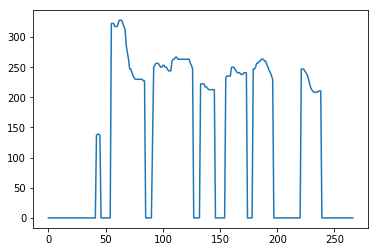

In [12]:
fda_ue_options = SimpleNamespace(
    windowlength=32, frameshift=15, left_padding=16, right_padding=16, datadir='../input', submission=None)
wav2f0(fda_ue_options, '../input/fda_ue.gui')

Processing: ../input/test/F1.wav


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


Processing: ../input/test/F2.wav
Processing: ../input/test/F3.wav
Processing: ../input/test/F4.wav
Processing: ../input/test/F5.wav
Processing: ../input/test/M1.wav
Processing: ../input/test/M2.wav
Processing: ../input/test/M3.wav
Processing: ../input/test/M4.wav
Processing: ../input/test/M5.wav


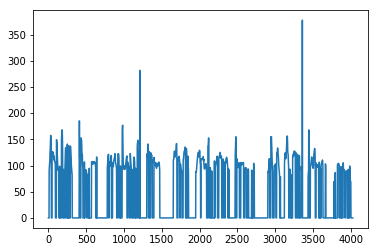

In [13]:
test_options = SimpleNamespace(
    windowlength=26.5, frameshift=10, left_padding=13.25, right_padding=7, datadir='../input/test', submission='submission.csv')
wav2f0(test_options, '../input/test.gui')